# 9章　MNISTを使った数字認識

In [1]:
# 必要ライブラリの導入

!pip install japanize_matplotlib | tail -n 1
!pip install torchviz | tail -n 1

In [2]:
# 必要ライブラリのインポート

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib

In [3]:
# torch関連ライブラリのインポート

import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torchviz import make_dot

In [4]:
# warning表示off
import warnings
warnings.simplefilter('ignore')

# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 14

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (6,6)

# デフォルトで方眼表示ON
plt.rcParams['axes.grid'] = True

# numpyの表示桁数設定
np.set_printoptions(suppress=True, precision=5)

## 9.3 ReLU関数

In [ ]:
# ReLU関数のグラフ

relu = nn.ReLU()
x_np = np.arange(-2, 2.1, 0.25)
x = torch.tensor(x_np).float()
y = relu(x)

plt.plot(x.data, y.data)
plt.title('ReLU関数')
plt.show()

## 8.4 GPU利用

### GPUチェック

In [6]:
# デバイスの割り当て
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [7]:
# テスト用tensor変数x , y 
x_np = np.arange(-2.0, 2.1, 0.25)
y_np = np.arange(-1.0, 3.1, 0.25)
x = torch.tensor(x_np).float()
y = torch.tensor(y_np).float()

# xとyの間の演算
z = x * y
print(z)

tensor([ 2.0000,  1.3125,  0.7500,  0.3125, -0.0000, -0.1875, -0.2500, -0.1875,
         0.0000,  0.3125,  0.7500,  1.3125,  2.0000,  2.8125,  3.7500,  4.8125,
         6.0000])


In [8]:
# 変数xをGPUに送る
x = x.to(device)

# 変数xとyの属性data, deviceの確認
print('x: ', x.device)
print('y: ', y.device)

x:  cpu
y:  cpu


In [9]:
# この状態でxとyの演算をすると。。。

z = x * y

In [10]:
# yもGPUに送る
y = y.to(device)

# 今度は計算可能になる
z = x * y
print(z)

tensor([ 2.0000,  1.3125,  0.7500,  0.3125, -0.0000, -0.1875, -0.2500, -0.1875,
         0.0000,  0.3125,  0.7500,  1.3125,  2.0000,  2.8125,  3.7500,  4.8125,
         6.0000])


## 9.8 データ準備1 (DataSetによる読み込み)

In [11]:
# !rm -rf ./data

In [12]:
# ライブラリインポート
import torchvision.datasets as datasets

train_set0 = datasets.MNIST(
    # 元データダウンロード先の指定
    root='./data',  
    # 訓練データか検証データか
    train=True,  
    # 元データがない場合にダウンロードするか
    download=True)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw





Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [13]:
# 読み込みデータの確認
!ls -lR ./data

./data:
total 4
drwxr-xr-x 4 root root 4096 Feb 14 02:51 MNIST

./data/MNIST:
total 8
drwxr-xr-x 2 root root 4096 Feb 14 02:51 processed
drwxr-xr-x 2 root root 4096 Feb 14 02:51 raw

./data/MNIST/processed:
total 54148
-rw-r--r-- 1 root root  7921081 Feb 14 02:51 test.pt
-rw-r--r-- 1 root root 47521081 Feb 14 02:51 training.pt

./data/MNIST/raw:
total 65008
-rw-r--r-- 1 root root  7840016 Feb 14 02:51 t10k-images-idx3-ubyte
-rw-r--r-- 1 root root  1648877 Feb 14 02:51 t10k-images-idx3-ubyte.gz
-rw-r--r-- 1 root root    10008 Feb 14 02:51 t10k-labels-idx1-ubyte
-rw-r--r-- 1 root root     4542 Feb 14 02:51 t10k-labels-idx1-ubyte.gz
-rw-r--r-- 1 root root 47040016 Feb 14 02:51 train-images-idx3-ubyte
-rw-r--r-- 1 root root  9912422 Feb 14 02:51 train-images-idx3-ubyte.gz
-rw-r--r-- 1 root root    60008 Feb 14 02:51 train-labels-idx1-ubyte
-rw-r--r-- 1 root root    28881 Feb 14 02:51 train-labels-idx1-ubyte.gz


### train_set0の確認

In [14]:
# データ件数の確認
print('データ件数: ', len(train_set0))

# 最初の要素の取得
image, label = train_set0[0]

# データ型の確認
print('入力データの型: ', type(image))
print('正解ラベルの型: ', type(label))

データ件数:  60000
入力データの型:  <class 'PIL.Image.Image'>
正解ラベルの型:  <class 'int'>


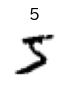

In [15]:
# 入力データの画像表示

plt.figure(figsize=(1,1))
plt.title(f'{label}')
plt.imshow(image, cmap='gray_r')
plt.axis('off')
plt.show()

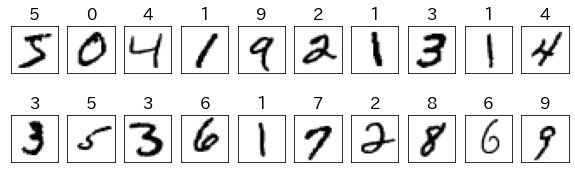

In [16]:
# 正解ラベル付きで、最初の20個をイメージ表示

plt.figure(figsize=(10, 3))
for i in range(20):
    ax = plt.subplot(2, 10, i + 1)
    
    # image と labelの取得
    image, label = train_set0[i]
    
    # イメージ表示
    plt.imshow(image, cmap='gray_r')
    ax.set_title(f'{label}')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


## 9.9 データ準備2 (Transformによるデータ前処理)

### Step1 ToTensorの利用

In [17]:
# ライブラリインポート
import torchvision.transforms as transforms

transform1 = transforms.Compose([
    # データのTensor化
    transforms.ToTensor(),
])

train_set1 = datasets.MNIST(
    root='./data',  train=True,  download=True,
    transform = transform1)

In [18]:
# 変換結果の確認

image, label = train_set1[0]
print('入力データの型: ', type(image))
print('入力データのshape: ', image.shape)
print('最小値: ', image.data.min())
print('最大値: ', image.data.max())

入力データの型:  <class 'torch.Tensor'>
入力データのshape:  torch.Size([1, 28, 28])
最小値:  tensor(0.)
最大値:  tensor(1.)


### Step2 Normalizeの利用

In [19]:
transform2 = transforms.Compose([
    # データのTensor化
    transforms.ToTensor(),
    
    # データの正規化
    transforms.Normalize(0.5,  0.5 ),
])

train_set2 = datasets.MNIST(
    root='./data',  train=True,  download=True,
    transform = transform2)

In [20]:
# 変換結果の確認

image, label = train_set2[0]
print('shape: ', image.shape)
print('最小値: ', image.data.min())
print('最大値: ', image.data.max())

shape:  torch.Size([1, 28, 28])
最小値:  tensor(-1.)
最大値:  tensor(1.)


### Step3 Lambdaを利用して1次元化¶

In [21]:
transform3 = transforms.Compose([
    # データのTensor化
    transforms.ToTensor(),
    
    # データの正規化
    transforms.Normalize(0.5, 0.5),
    
    # Tensorの1次元化
    transforms.Lambda(lambda x: x.view(-1)),
])

train_set3 = datasets.MNIST(
    root='./data',  train=True,  download=True,
    transform = transform3)

In [22]:
# 変換結果の確認

image, label = train_set3[0]
print('shape: ', image.shape)
print('最小値: ', image.data.min())
print('最大値: ', image.data.max())

shape:  torch.Size([784])
最小値:  tensor(-1.)
最大値:  tensor(1.)


### 最終的な実装

In [23]:
# データ変換用関数 Transformer
#  (1) ImageをTensor化
#  (2) [0, 1]の範囲の値を[-1, 1]の範囲に変換する
# (3) データのshapeを(1, 28, 28)の3次元から(784,)の1次元の変換

transform = transforms.Compose([
    # データのTensor化
    transforms.ToTensor(),
    
    # データの正規化
    transforms.Normalize(0.5, 0.5),
    
    # Tensorの1次元化
    transforms.Lambda(lambda x: x.view(-1)),
])

In [24]:
# データ取得用関数 DataSet

# 訓練用データセットの定義
train_set = datasets.MNIST(
    root='./data', 
    train=True,
    download=True,
    transform=transform)

# 検証データセットの定義
test_set = datasets.MNIST(
    root='./data', 
    train=False, 
    download=True, 
    transform=transform)

## 9.10 データ準備3 (DataLoaderによるミニバッチ用データ生成)

In [25]:
# ライブラリインポート
from torch.utils.data import DataLoader

# ミニバッチのサイズ指定
batch_size = 512

# 訓練用データローダー
# 訓練用なので、シャッフルをかける
train_loader = DataLoader(
    train_set, 
    batch_size=batch_size, 
    shuffle=True)

# 検証用データローダー
# 検証時にシャッフルは不要
test_loader = DataLoader(
    test_set,  
    batch_size=batch_size, 
    shuffle=False) 

In [43]:
# 何組のデータが取得できるか
print(len(train_loader))

# DataLoaderから最初の1セットを取得する
for images, labels in train_loader:
    break

print(images.shape)
print(labels.shape)

118
torch.Size([512, 784])
torch.Size([512])


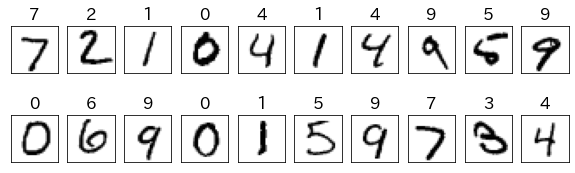

In [27]:
# イメージ表示
plt.figure(figsize=(10, 3))
for i in range(20):
    ax = plt.subplot(2, 10, i + 1)
    
    # numpyに変換
    image = images[i].numpy()
    label = labels[i]
    
    # imgの範囲を[0, 1]に戻す
    image2 = (image + 1)/ 2
    
    # イメージ表示
    plt.imshow(image2.reshape(28, 28),cmap='gray_r')
    ax.set_title(f'{label}')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

全体で10000件ある学習データが512個のグループに分割されて取得できていることがわかる。  
今回はテスト用でシャッフルなしでデータを取得したが、訓練用データは取得のたびにシャッフルがかかる。  
つまり、ミニバッチ用のデータセットが自動的に取得できていることになる。

## 9.11 モデル定義

In [ ]:
# どこに置くか要検討 (2-13 11:00)

# 分類先クラス一覧
#classes = tuple(np.linspace(0, 9, 10, dtype=np.uint8))

In [44]:
# 入力次元数
n_input = image.shape[0]

# 出力次元数
# 分類先クラス数　今回は10になる
n_output = len(set(list(labels.data.numpy())))

#   隠れ層のノード数
n_hidden = 128

# 結果確認
print(f'n_input: {n_input}  n_hidden: {n_hidden} n_output: {n_output}')

n_input: 784  n_hidden: 128 n_output: 10


In [45]:
# モデルの定義
# 784入力10出力1隠れ層のニューラルネットワークモデル

class Net(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super().__init__()

        # 隠れ層の定義 (隠れ層のノード数: n_hidden)
        self.l1 = nn.Linear(n_input, n_hidden)

        # 出力層の定義
        self.l2 = nn.Linear(n_hidden, n_output)

        # ReLU関数の定義
        self.relu = nn.ReLU(inplace=True)
   
    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.relu(x1)
        x3 = self.l2(x2)
        return x3

In [46]:
# インスタンスの生成
net = Net(n_input, n_output, n_hidden)

# モデルをGPU側に送る
net = net.to(device)

### 最適化アルゴリズムと損失関数

In [47]:
# 学習率
lr = 0.01

# アルゴリズム: 勾配降下法
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()


### モデル確認

In [48]:
# モデル内のパラメータの確認
# l1.weight, l1.bias, l2.weight, l2.biasがあることがわかる

for parameter in net.named_parameters():
    print(parameter)

('l1.weight', Parameter containing:
tensor([[-0.0012, -0.0029,  0.0118,  ...,  0.0105, -0.0117, -0.0348],
        [-0.0070, -0.0139,  0.0201,  ..., -0.0349, -0.0345, -0.0154],
        [ 0.0018,  0.0344, -0.0107,  ..., -0.0260,  0.0128, -0.0324],
        ...,
        [-0.0103,  0.0214, -0.0058,  ..., -0.0010,  0.0026,  0.0300],
        [ 0.0151,  0.0332, -0.0222,  ..., -0.0269, -0.0083,  0.0049],
        [-0.0347, -0.0127,  0.0227,  ...,  0.0135, -0.0008,  0.0226]],
       device='cuda:0', requires_grad=True))
('l1.bias', Parameter containing:
tensor([ 0.0196,  0.0262, -0.0214,  0.0296, -0.0167, -0.0213, -0.0184,  0.0216,
        -0.0187,  0.0180,  0.0109, -0.0197,  0.0353,  0.0144,  0.0332, -0.0167,
        -0.0027,  0.0171,  0.0039,  0.0313, -0.0066,  0.0218, -0.0050, -0.0239,
        -0.0188,  0.0127, -0.0216,  0.0245, -0.0122, -0.0262, -0.0179,  0.0338,
        -0.0332,  0.0136,  0.0016,  0.0067, -0.0340, -0.0085,  0.0101,  0.0334,
         0.0228, -0.0130, -0.0089, -0.0034, -0.0132

In [49]:
# モデルの概要表示

print(net)

Net(
  (l1): Linear(in_features=784, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU(inplace=True)
)


In [50]:
# モデルのサマリー表示

summary(net, (784,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]         100,480
              ReLU-2                  [-1, 128]               0
            Linear-3                   [-1, 10]           1,290
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.39
Estimated Total Size (MB): 0.39
----------------------------------------------------------------


## 9.12 勾配降下法

### 順伝搬

In [51]:
# 訓練データセット　最初の1項目を取得
# DataLoaderから最初の1セットを取得する
for images, labels in train_loader:
    break 

In [52]:
# Loaderから取得したデータをGPUに送る
inputs = images.to(device)
labels = labels.to(device)

In [53]:
# 予測値の計算
outputs = net(inputs)

# 結果確認
print(outputs)

tensor([[-0.2245, -0.0396,  0.5168,  ...,  0.0335,  0.0472, -0.2423],
        [-0.1158,  0.0516,  0.3674,  ...,  0.2594,  0.0192, -0.1974],
        [-0.2654, -0.1410,  0.5311,  ...,  0.0016, -0.1522, -0.3630],
        ...,
        [-0.4350, -0.0843,  0.4217,  ..., -0.0385, -0.0671, -0.3601],
        [-0.3245, -0.0113,  0.3675,  ...,  0.1007, -0.0014, -0.2784],
        [-0.1512,  0.0024,  0.4750,  ...,  0.2074,  0.2625, -0.1139]],
       device='cuda:0', grad_fn=<AddmmBackward>)


### 損失関数

2.3385438919067383


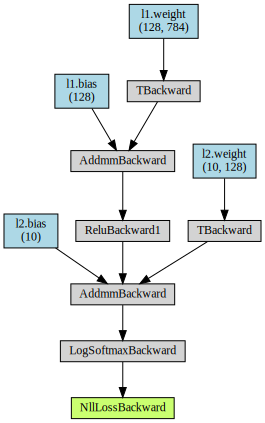

In [54]:
#  損失値の計算
loss = criterion(outputs, labels)

# 損失値の取得
print(loss.item())

# 損失関数のグラフ化
make_dot(loss, params=dict(net.named_parameters()))

### 勾配計算

In [55]:
# 勾配計算の実行
loss.backward()

In [56]:
# 勾配計算の結果
w = net.to('cpu')
print(w.l1.weight.grad.numpy())
print(w.l1.bias.grad.numpy())
print(w.l2.weight.grad.numpy())
print(w.l2.bias.grad.numpy())

[[-0.00327 -0.00327 -0.00327 ... -0.00327 -0.00327 -0.00327]
 [-0.00117 -0.00117 -0.00117 ... -0.00117 -0.00117 -0.00117]
 [-0.00749 -0.00749 -0.00749 ... -0.00749 -0.00749 -0.00749]
 ...
 [ 0.00191  0.00191  0.00191 ...  0.00191  0.00191  0.00191]
 [-0.00248 -0.00248 -0.00248 ... -0.00248 -0.00248 -0.00248]
 [-0.00271 -0.00271 -0.00271 ... -0.00271 -0.00271 -0.00271]]
[ 0.00327  0.00117  0.00749 -0.00305  0.00036  0.00072  0.00013 -0.00221
 -0.00042 -0.00528  0.00707  0.00948 -0.00776 -0.00052  0.00297  0.00476
 -0.00026  0.0028  -0.00121  0.00098  0.00045 -0.00583  0.00034 -0.00112
  0.00006 -0.00659 -0.00036  0.00111 -0.00202  0.00327  0.00346  0.00105
 -0.0025  -0.00439 -0.00472  0.00614  0.00672  0.01098 -0.00604 -0.00082
 -0.00026  0.01005 -0.00423  0.00223 -0.00187  0.00271 -0.01073  0.00024
 -0.00749  0.00173 -0.00016 -0.00446  0.00538  0.00373  0.00382  0.00127
  0.      -0.00058 -0.00025  0.00092  0.00011  0.00644  0.00469  0.00021
  0.00294  0.00404  0.00085  0.00945  0.0021

### 重み行列の修正

In [57]:
# 勾配降下法の適用
optimizer.step()

In [58]:
# 重み行列の結果
print(net.l1.weight)
print(net.l1.bias)

Parameter containing:
tensor([[-0.0011, -0.0028,  0.0119,  ...,  0.0105, -0.0117, -0.0348],
        [-0.0070, -0.0139,  0.0202,  ..., -0.0349, -0.0345, -0.0154],
        [ 0.0018,  0.0345, -0.0107,  ..., -0.0259,  0.0129, -0.0323],
        ...,
        [-0.0103,  0.0214, -0.0058,  ..., -0.0010,  0.0026,  0.0300],
        [ 0.0151,  0.0332, -0.0222,  ..., -0.0269, -0.0082,  0.0049],
        [-0.0346, -0.0127,  0.0227,  ...,  0.0135, -0.0008,  0.0226]],
       requires_grad=True)
Parameter containing:
tensor([ 0.0196,  0.0262, -0.0215,  0.0296, -0.0167, -0.0213, -0.0184,  0.0216,
        -0.0187,  0.0180,  0.0109, -0.0198,  0.0354,  0.0144,  0.0332, -0.0167,
        -0.0027,  0.0171,  0.0039,  0.0313, -0.0066,  0.0218, -0.0050, -0.0239,
        -0.0188,  0.0127, -0.0216,  0.0245, -0.0122, -0.0263, -0.0179,  0.0338,
        -0.0331,  0.0137,  0.0017,  0.0066, -0.0341, -0.0087,  0.0101,  0.0334,
         0.0228, -0.0131, -0.0089, -0.0034, -0.0131, -0.0144,  0.0177,  0.0179,
        -0.0210

### 繰り返し計算

In [59]:
# 学習率
lr = 0.01

# モデル初期化
net = Net(n_input, n_output, n_hidden).to(device)

# 最適化アルゴリズム: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 繰り返し回数
num_epochs = 100

# 評価結果記録用
history = np.zeros((0,5))

In [60]:
# 繰り返し計算メインループ

for epoch in range(num_epochs):
    train_acc = 0
    train_loss = 0
    val_acc = 0
    val_loss = 0
    n_train = 0
    n_test = 0

    # 学習フェーズ
    for inputs, labels in train_loader:
        n_train += len(labels)

        # GPUヘ転送
        inputs = inputs.to(device)
        labels = labels.to(device)
    
        #勾配の初期化
        optimizer.zero_grad()

        # 順伝搬計算
        outputs = net(inputs)

        # 損失計算
        loss = criterion(outputs, labels)

        # 勾配計算
        loss.backward()
    
        # 重み調整
        optimizer.step()

        #予測ラベル導出
        predicted = torch.max(outputs, 1)[1]

        # 訓練データに対する損失と精度の計算
        train_loss += loss.item()
        train_acc += (predicted == labels).sum() 

    #予測フェーズ
    for inputs_test, labels_test in test_loader:
        n_test += len(labels_test)

        inputs_test = inputs_test.to(device)
        labels_test = labels_test.to(device)

            
        # 順伝搬計算
        outputs_test = net(inputs_test)

        # 誤差計算
        loss_test = criterion(outputs_test, labels_test)

        #予測ラベル導出
        predicted_test = torch.max(outputs_test, 1)[1]

        # 検証データに対する損失と精度の計算
        val_loss +=  loss_test.item()
        val_acc +=  (predicted_test == labels_test).sum()

    # 評価値の算出・記録
    train_acc = train_acc / n_train
    val_acc = val_acc / n_test
    train_loss = train_loss * batch_size / n_train
    val_loss = val_loss * batch_size / n_test
    print (f'Epoch [{epoch+1}/{num_epochs}], loss: {train_loss:.5f} acc: {train_acc:.5f} val_loss: {val_loss:.5f}, val_acc: {val_acc:.5f}')
    item = np.array([epoch+1 , train_loss, train_acc, val_loss, val_acc])
    history = np.vstack((history, item))

Epoch [1/100], loss: 1.92811 acc: 0.52918 val_loss: 1.48190, val_acc: 0.71490
Epoch [2/100], loss: 1.13198 acc: 0.78000 val_loss: 0.88678, val_acc: 0.83020
Epoch [3/100], loss: 0.75508 acc: 0.83380 val_loss: 0.65485, val_acc: 0.85450
Epoch [4/100], loss: 0.60065 acc: 0.85535 val_loss: 0.54862, val_acc: 0.87070
Epoch [5/100], loss: 0.52190 acc: 0.86767 val_loss: 0.48897, val_acc: 0.87900
Epoch [6/100], loss: 0.47289 acc: 0.87557 val_loss: 0.45051, val_acc: 0.88730
Epoch [7/100], loss: 0.44141 acc: 0.88190 val_loss: 0.42413, val_acc: 0.89100
Epoch [8/100], loss: 0.41778 acc: 0.88550 val_loss: 0.40240, val_acc: 0.89580
Epoch [9/100], loss: 0.39985 acc: 0.88910 val_loss: 0.38866, val_acc: 0.89670
Epoch [10/100], loss: 0.38654 acc: 0.89225 val_loss: 0.37466, val_acc: 0.89930
Epoch [11/100], loss: 0.37401 acc: 0.89493 val_loss: 0.36710, val_acc: 0.90000
Epoch [12/100], loss: 0.36576 acc: 0.89730 val_loss: 0.35907, val_acc: 0.90230
Epoch [13/100], loss: 0.35659 acc: 0.89918 val_loss: 0.35015,

## 9.13 結果確認

In [ ]:
#損失関数値と精度の確認

print(f'初期状態: 損失関数値: {history[0,3]:.5f} 精度: {history[0,4]:.5f}' )
print(f'最終状態: 損失関数値: {history[-1,3]:.5f} 精度: {history[-1,4]:.5f}' )

初期状態: 損失関数値: 1.41635 精度: 0.75480
最終状態: 損失関数値: 0.17674 精度: 0.95140


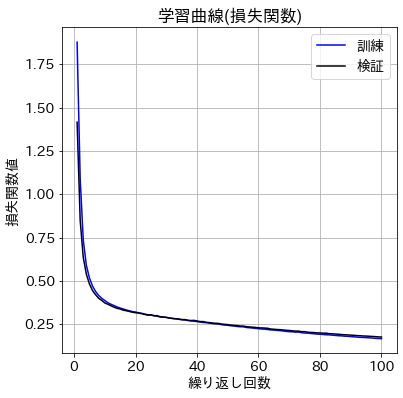

In [ ]:
# 学習曲線の表示 (損失関数)

plt.plot(history[:,0], history[:,1], 'b', label='訓練')
plt.plot(history[:,0], history[:,3], 'k', label='検証')
plt.xlabel('繰り返し回数')
plt.ylabel('損失関数値')
plt.title('学習曲線(損失関数)')
plt.legend()
plt.show()

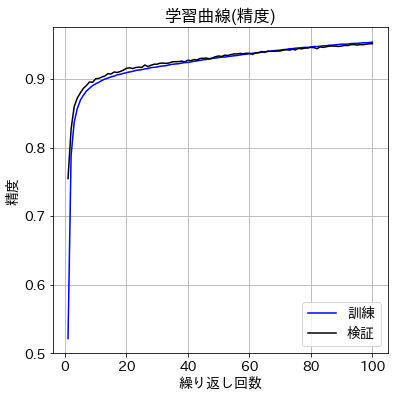

In [ ]:
# 学習曲線の表示 (精度)

plt.plot(history[:,0], history[:,2], 'b', label='訓練')
plt.plot(history[:,0], history[:,4], 'k', label='検証')
plt.xlabel('繰り返し回数')
plt.ylabel('精度')
plt.title('学習曲線(精度)')
plt.legend()
plt.show()

### イメージ表示で確認

In [62]:
# DataLoaderから最初の1セットを取得する
for images, labels in test_loader:
    break

# 予測結果の取得
inputs = images.to(device)
labels = labels.to(device)
outputs = net(inputs)
predicted = torch.max(outputs, 1)[1]

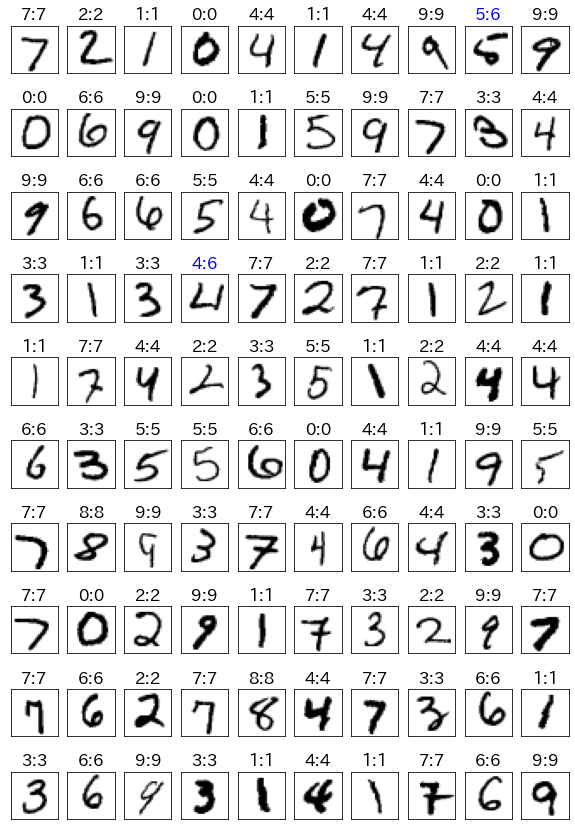

In [64]:
# 最初の100件でイメージを「正解値:予測値」と表示

plt.figure(figsize=(10, 15))
for i in range(100):
  ax = plt.subplot(10, 10, i + 1)
    
  # numpyに変換
  image = images[i]
  label = labels[i]
  pred = predicted[i]
  if (pred == label):
    c = 'k'
  else:
    c = 'b'
    
  # imgの範囲を[0, 1]に戻す
  image2 = (image + 1)/ 2
    
  # イメージ表示
  plt.imshow(image2.reshape(28, 28),cmap='gray_r')
  ax.set_title(f'{label}:{pred}', c=c)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()


## 9.14 隠れ層の2層化

In [65]:
# モデルの定義
# 784入力10出力2隠れ層のニューラルネットワークモデル

class Net(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super().__init__()
        
        # 隠れ層1の定義 (隠れ層のノード数: n_hidden)
        self.l1 = nn.Linear(n_input, n_hidden)

        # 隠れ層2の定義 (隠れ層のノード数: n_hidden)
        self.l2 = nn.Linear(n_hidden, n_hidden)

        # 出力層の定義
        self.l3 = nn.Linear(n_hidden, n_output)

        # Relu関数の定義
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.relu(x1)
        x3 = self.l2(x2)
        x4 = self.relu(x3)
        x5 = self.l3(x4)
        return x5

In [66]:
# インスタンスの生成
net = Net(n_input, n_output, n_hidden).to(device)

# アルゴリズム: 勾配降下法
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

In [67]:
# モデルの概要表示

print(net)

Net(
  (l1): Linear(in_features=784, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=128, bias=True)
  (l3): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU(inplace=True)
)


In [68]:
# モデルのサマリー表示

summary(net, (784,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]         100,480
              ReLU-2                  [-1, 128]               0
            Linear-3                  [-1, 128]          16,512
              ReLU-4                  [-1, 128]               0
            Linear-5                   [-1, 10]           1,290
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.45
Estimated Total Size (MB): 0.46
----------------------------------------------------------------


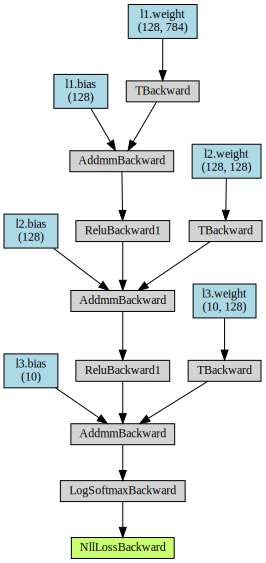

In [69]:
# 予測値の計算
outputs = net(inputs)

#  損失値の計算
loss = criterion(outputs, labels)

# 損失関数のグラフ化
make_dot(loss, params=dict(net.named_parameters()))

### 勾配計算

In [70]:
# 勾配計算の実行
loss.backward()

# 勾配計算結果の一部
w = net.to('cpu')
print(w.l1.weight.grad.numpy())

[[ 0.00086  0.00086  0.00086 ...  0.00086  0.00086  0.00086]
 [ 0.00008  0.00008  0.00008 ...  0.00008  0.00008  0.00008]
 [-0.00005 -0.00005 -0.00005 ... -0.00005 -0.00005 -0.00005]
 ...
 [ 0.00103  0.00103  0.00103 ...  0.00103  0.00103  0.00103]
 [-0.00152 -0.00152 -0.00152 ... -0.00152 -0.00152 -0.00152]
 [ 0.00014  0.00014  0.00014 ...  0.00014  0.00014  0.00014]]


In [71]:
# 初期化
net = Net(n_input, n_output, n_hidden).to(device)

# 最適化アルゴリズム: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 繰り返し回数
num_epochs = 200

# 評価結果記録用
history2 = np.zeros((0,5))

In [72]:
# 繰り返し計算メインループ

for epoch in range(num_epochs):
    train_acc = 0
    train_loss = 0
    val_acc = 0
    val_loss = 0
    n_train = 0
    n_test = 0

    # 学習フェーズ
    for inputs, labels in train_loader:
        n_train += len(labels)

        # GPUヘ転送
        inputs = inputs.to(device)
        labels = labels.to(device)
    
        #勾配の初期化
        optimizer.zero_grad()

        # 順伝搬計算
        outputs = net(inputs)

        # 損失計算
        loss = criterion(outputs, labels)

        # 勾配計算
        loss.backward()
    
        # 重み調整
        optimizer.step()

        #予測ラベル導出
        predicted = torch.max(outputs, 1)[1]

        # 訓練データに対する損失と精度の計算
        train_loss += loss.item()
        train_acc += (predicted == labels).sum() 

    #予測フェーズ
    for inputs_test, labels_test in test_loader:
        n_test += len(labels_test)

        inputs_test = inputs_test.to(device)
        labels_test = labels_test.to(device)

        # 順伝搬計算
        outputs_test = net(inputs_test)

        # 誤差計算
        loss_test = criterion(outputs_test, labels_test)

        #予測ラベル導出
        predicted_test = torch.max(outputs_test, 1)[1]

        # 検証データに対する損失と精度の計算
        val_loss +=  loss_test.item()
        val_acc +=  (predicted_test == labels_test).sum()

    # 評価値の算出・記録
    train_acc = train_acc / n_train
    val_acc = val_acc / n_test
    train_loss = train_loss * batch_size / n_train
    val_loss = val_loss * batch_size / n_test
    print (f'Epoch [{epoch+1}/{num_epochs}], loss: {train_loss:.5f} acc: {train_acc:.5f} val_loss: {val_loss:.5f}, val_acc: {val_acc:.5f}')
    item = np.array([epoch+1 , train_loss, train_acc, val_loss, val_acc])
    history2 = np.vstack((history2, item))

Epoch [1/200], loss: 2.23361 acc: 0.31340 val_loss: 2.14330, val_acc: 0.50850
Epoch [2/200], loss: 1.86649 acc: 0.57497 val_loss: 1.57058, val_acc: 0.66140
Epoch [3/200], loss: 1.24999 acc: 0.72308 val_loss: 1.00421, val_acc: 0.78930
Epoch [4/200], loss: 0.84759 acc: 0.80403 val_loss: 0.73078, val_acc: 0.82580
Epoch [5/200], loss: 0.65469 acc: 0.83288 val_loss: 0.59170, val_acc: 0.85730
Epoch [6/200], loss: 0.54913 acc: 0.85360 val_loss: 0.50924, val_acc: 0.87010
Epoch [7/200], loss: 0.48754 acc: 0.86840 val_loss: 0.45725, val_acc: 0.88290
Epoch [8/200], loss: 0.44727 acc: 0.87858 val_loss: 0.42377, val_acc: 0.88680
Epoch [9/200], loss: 0.41710 acc: 0.88412 val_loss: 0.39993, val_acc: 0.89040
Epoch [10/200], loss: 0.39747 acc: 0.88818 val_loss: 0.38097, val_acc: 0.89760
Epoch [11/200], loss: 0.38018 acc: 0.89283 val_loss: 0.36793, val_acc: 0.89770
Epoch [12/200], loss: 0.36959 acc: 0.89568 val_loss: 0.36483, val_acc: 0.89830
Epoch [13/200], loss: 0.35744 acc: 0.89782 val_loss: 0.35285,

In [73]:
#損失関数値と精度の確認

print(f'初期状態: 損失関数値: {history2[0,3]:.5f} 精度: {history2[0,4]:.5f}' )
print(f'最終状態: 損失関数値: {history2[-1,3]:.5f} 精度: {history2[-1,4]:.5f}' )

初期状態: 損失関数値: 2.14330 精度: 0.50850
最終状態: 損失関数値: 0.10158 精度: 0.96980


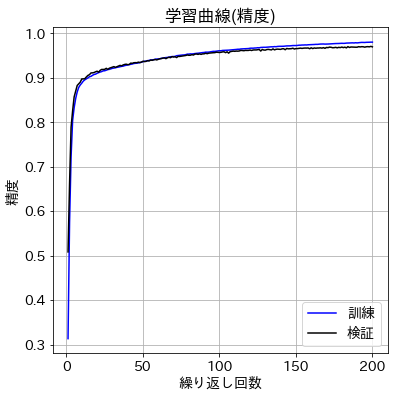

In [74]:
# 学習曲線の表示 (精度)

plt.plot(history2[:,0], history2[:,2], 'b', label='訓練')
plt.plot(history2[:,0], history2[:,4], 'k', label='検証')
plt.xlabel('繰り返し回数')
plt.ylabel('精度')
plt.title('学習曲線(精度)')
plt.legend()
plt.show()

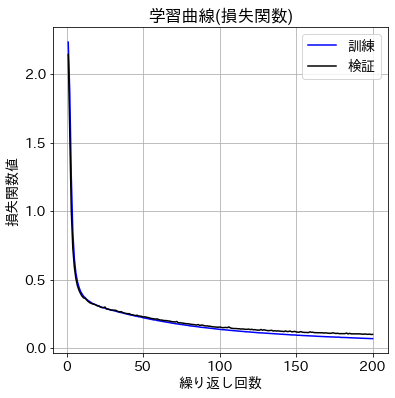

In [75]:
# 学習曲線の表示 (損失関数)
plt.plot(history2[:,0], history2[:,1], 'b', label='訓練')
plt.plot(history2[:,0], history2[:,3], 'k', label='検証')
plt.xlabel('繰り返し回数')
plt.ylabel('損失関数値')
plt.title('学習曲線(損失関数)')
plt.legend()
plt.show()

## コラム　勾配消失とReLU関数

In [76]:
# モデルの定義　シグモイド関数バージョン
# 784入力10出力2隠れ層のニューラルネットワークモデル

class Net(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super().__init__()
        
        # 隠れ層1の定義 (隠れ層のノード数: n_hidden)
        self.l1 = nn.Linear(n_input, n_hidden)

        # 隠れ層2の定義 (隠れ層のノード数: n_hidden)
        self.l2 = nn.Linear(n_hidden, n_hidden)

        # 出力層の定義
        self.l3 = nn.Linear(n_hidden, n_output)

        # シグモイド関数の定義
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.sigmoid(x1)
        x3 = self.l2(x2)
        x4 = self.sigmoid(x3)
        x5 = self.l3(x4)
        return x5

In [77]:
# インスタンスの生成
net = Net(n_input, n_output, n_hidden).to(device)

# アルゴリズム: 勾配降下法
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

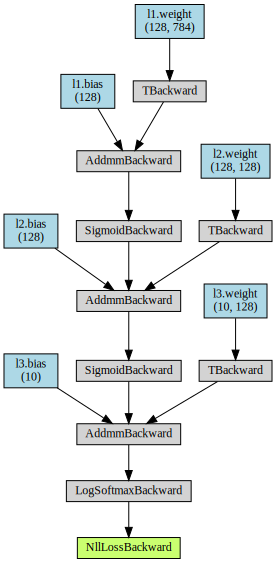

In [78]:
# 予測値の計算
outputs = net(inputs)

#  損失値の計算
loss = criterion(outputs, labels)

# 損失関数のグラフ化
make_dot(loss, params=dict(net.named_parameters()))

In [79]:
# 勾配計算の実行
loss.backward()

# 勾配計算結果の一部
w = net.to('cpu')
print(w.l1.weight.grad.numpy())

[[-0.00013 -0.00013 -0.00013 ... -0.00013 -0.00013 -0.00013]
 [-0.00034 -0.00034 -0.00034 ... -0.00034 -0.00034 -0.00034]
 [ 0.0001   0.0001   0.0001  ...  0.0001   0.0001   0.0001 ]
 ...
 [ 0.0002   0.0002   0.0002  ...  0.0002   0.0002   0.0002 ]
 [ 0.00025  0.00025  0.00025 ...  0.00025  0.00025  0.00025]
 [-0.00001 -0.00001 -0.00001 ... -0.00001 -0.00001 -0.00001]]


## コラム 「ディープラーニングの数学」との結果比較

### batch_size=100に変更

In [80]:
# ミニバッチのサイズ指定
batch_size = 100

# 訓練用データローダー
# 訓練用なので、シャッフルをかける
train_loader = DataLoader(
    train_set, 
    batch_size=batch_size, 
    shuffle=True)

# 検証用データローダー
# 検証時にシャッフルは不要
test_loader = DataLoader(
    test_set,  
    batch_size=batch_size, 
    shuffle=False) 

In [81]:
# モデルの定義
# 784入力10出力1隠れ層のニューラルネットワークモデル

class Net(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super().__init__()

        # 隠れ層の定義 (隠れ層のノード数: n_hidden)
        self.l1 = nn.Linear(n_input, n_hidden)

        # 出力層の定義
        self.l2 = nn.Linear(n_hidden, n_output)

        # ReLU関数の定義
        self.relu = nn.ReLU(inplace=True)
   
    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.relu(x1)
        x3 = self.l2(x2)
        return x3

In [82]:
# 学習率
lr = 0.01

# モデル初期化
net = Net(n_input, n_output, n_hidden).to(device)

# 最適化アルゴリズム: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 繰り返し回数
num_epochs = 100

# 評価結果記録用
history3 = np.zeros((0,5))

In [83]:
# 繰り返し計算メインループ

for epoch in range(num_epochs):
    train_acc = 0
    train_loss = 0
    val_acc = 0
    val_loss = 0
    n_train = 0
    n_test = 0

    # 学習フェーズ
    for inputs, labels in train_loader:
        n_train += len(labels)

        # GPUヘ転送
        inputs = inputs.to(device)
        labels = labels.to(device)
    
        #勾配の初期化
        optimizer.zero_grad()

        # 順伝搬計算
        outputs = net(inputs)

        # 損失計算
        loss = criterion(outputs, labels)

        # 勾配計算
        loss.backward()
    
        # 重み調整
        optimizer.step()

        #予測ラベル導出
        predicted = torch.max(outputs, 1)[1]

        # 訓練データに対する損失と精度の計算
        train_loss += loss.item()
        train_acc += (predicted == labels).sum() 

    #予測フェーズ
    for inputs_test, labels_test in test_loader:
        n_test += len(labels_test)

        inputs_test = inputs_test.to(device)
        labels_test = labels_test.to(device)

        # 順伝搬計算
        outputs_test = net(inputs_test)

        # 誤差計算
        loss_test = criterion(outputs_test, labels_test)

        #予測ラベル導出
        predicted_test = torch.max(outputs_test, 1)[1]

        # 検証データに対する損失と精度の計算
        val_loss +=  loss_test.item()
        val_acc +=  (predicted_test == labels_test).sum()

    # 評価値の算出・記録
    train_acc = train_acc / n_train
    val_acc = val_acc / n_test
    train_loss = train_loss * batch_size / n_train
    val_loss = val_loss * batch_size / n_test
    print (f'Epoch [{epoch+1}/{num_epochs}], loss: {train_loss:.5f} acc: {train_acc:.5f} val_loss: {val_loss:.5f}, val_acc: {val_acc:.5f}')
    item = np.array([epoch+1 , train_loss, train_acc, val_loss, val_acc])
    history3 = np.vstack((history3, item))

Epoch [1/100], loss: 0.93200 acc: 0.77952 val_loss: 0.45879, val_acc: 0.88120
Epoch [2/100], loss: 0.41647 acc: 0.88568 val_loss: 0.35588, val_acc: 0.90130
Epoch [3/100], loss: 0.35569 acc: 0.89895 val_loss: 0.32422, val_acc: 0.90640
Epoch [4/100], loss: 0.32707 acc: 0.90660 val_loss: 0.30241, val_acc: 0.91250
Epoch [5/100], loss: 0.30712 acc: 0.91177 val_loss: 0.29292, val_acc: 0.91500
Epoch [6/100], loss: 0.29169 acc: 0.91605 val_loss: 0.27576, val_acc: 0.92040
Epoch [7/100], loss: 0.27877 acc: 0.92002 val_loss: 0.26693, val_acc: 0.92240
Epoch [8/100], loss: 0.26637 acc: 0.92373 val_loss: 0.25631, val_acc: 0.92550
Epoch [9/100], loss: 0.25522 acc: 0.92743 val_loss: 0.24362, val_acc: 0.93050
Epoch [10/100], loss: 0.24461 acc: 0.93052 val_loss: 0.23363, val_acc: 0.93320
Epoch [11/100], loss: 0.23451 acc: 0.93350 val_loss: 0.22809, val_acc: 0.93550
Epoch [12/100], loss: 0.22511 acc: 0.93625 val_loss: 0.21735, val_acc: 0.93770
Epoch [13/100], loss: 0.21656 acc: 0.93918 val_loss: 0.21210,

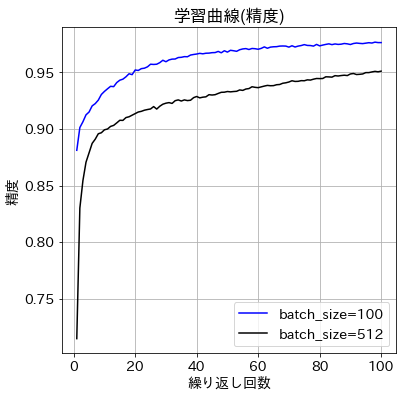

In [84]:
# 学習曲線の表示 (精度)

plt.plot(history3[:,0], history3[:,4], 'b', label='batch_size=100')
plt.plot(history[:,0], history[:,4], 'k', label='batch_size=512')
plt.xlabel('繰り返し回数')
plt.ylabel('精度')
plt.title('学習曲線(精度)')
plt.legend()
plt.show()

## コラム　lambda式による関数定義

In [11]:
# 通常の関数定義

def f(x):
    return (2 * x**2 + 2)

In [12]:
x = np.arange(-2, 2.1, 0.25)
y = f(x)
print(y)

[10.     8.125  6.5    5.125  4.     3.125  2.5    2.125  2.     2.125
  2.5    3.125  4.     5.125  6.5    8.125 10.   ]


In [13]:
# lambda式による関数定義

g = lambda x: 2 * x**2 + 2

In [15]:
y = g(x)
print(y)

[10.     8.125  6.5    5.125  4.     3.125  2.5    2.125  2.     2.125
  2.5    3.125  4.     5.125  6.5    8.125 10.   ]
